In [1]:
# importing packages and modules
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

# code from summer project working with PWM data
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'LC_PWM_GLM-HMM/code')))
import io_utils, analysis_utils, plotting_utils

In [2]:
# rat ids to look at first
animal_ids = ['W073','W075']

### Data Prep and CV

In [8]:
sigmaList = [0.008,0.04,0.09,0.2,0.45,1,2.23,5,11.18,25,125]
df = io_utils.load_and_wrangle(rat_id='W073', path=None, psychometric=True, cutoff=10, overwrite=False, stage_filter=2)
print(len(df.index.tolist()))
x, y = io_utils.prepare_design_matrices(rat_id='W073', path=None, psychometric=True, cutoff=10, stage_filter=2, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W073', path=None, psychometric=True, cutoff=10, stage_filter=2))



146771


In [9]:
folds = 3
trainX, trainY, trainSessInd, testX, testY, testSessInd = split_data_per_session(x, y, sessInd, folds=3, random_state=1)

In [14]:
print(testX[2].shape)

(48717, 6)


### Fitting single sigma

In [27]:
N = x.shape[0]
C = 2 # classes
K = 2 # states
D = x.shape[1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma= reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=2, tol=1e-4) # fit the model
print(np.argmax(checkLl))

KeyboardInterrupt: 

In [5]:
for k in [1,2]:
    N = x.shape[0]
    C = 2 # classes
    K = k # states
    D = x.shape[1]
    dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
    initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
    checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma= reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=250, tol=1e-3) # fit the model
    np.save(f'../data/P_{k}_state_PWM', checkP)
    np.save(f'../data/Ll_{k}_state_PWM', checkLl)
    np.save(f'../data/W_{k}_state_PWM', checkW)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
0
1


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:394: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities
/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:394: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities


2


/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:394: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities
/Users/lencacuturela/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/lencacuturela/Desktop/Research/github/Pillow_dGLM-HMM/code/dglm_hmm1.py:394: RuntimeWarning: divide by zero encountered in log
  logPhi = np.log(phi) # natural log of observation probabilities


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


KeyboardInterrupt: 

In [6]:
np.save(f'../data/P_2_state_100iter_PWM', checkP)
np.save(f'../data/Ll_2_state_100iter_PWM', checkLl)
np.save(f'../data/W_2_state_100iter_PWM', checkW)

### Fitting multiple sigmas

In [3]:
sigmaList = [0, 0.01, 0.1, 1, 10, 100]
fit_eval_CV_multiple_sigmas_PWM(rat_id='W073', stage_filter=2, K=2, folds=2, sigmaList=[0, 1], maxiter=10, save=False)

0


KeyboardInterrupt: 

### Verifying against PsyTrack

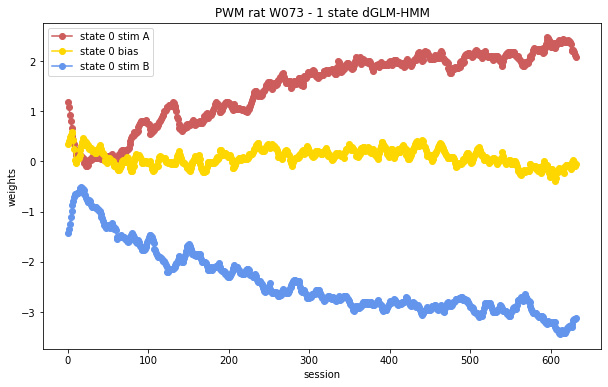

In [36]:
checkP = np.load(f'../data/P_1_state_PWM.npy')
checkLl = np.load(f'../data/Ll_1_state_PWM.npy')
checkW = np.load(f'../data/W_1_state_PWM.npy')

sess = len(sessInd)-1
plt.figure(figsize=(10,6))
plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,1,0],color='indianred',marker='o',label='state 0 stim A')
plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,0,0],color='gold',marker='o', label='state 0 bias')
plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,2,0],color='cornflowerblue',marker='o', label='state 0 stim B')

plt.title('PWM rat W073 - 1 state dGLM-HMM')
#plt.xticks(range(1,sess+1))
plt.ylabel("weights")
plt.xlabel('session')
plt.legend()
#plt.legend(fontsize='xx-small')
plt.show()


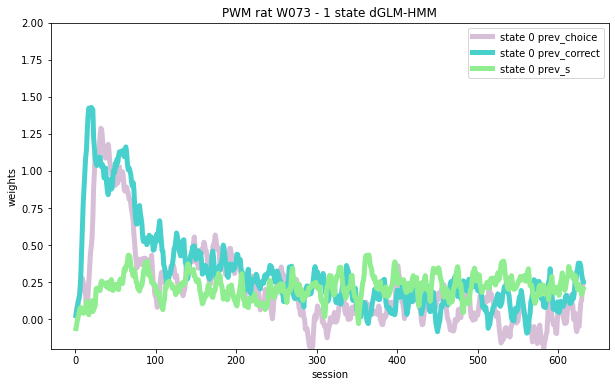

In [38]:
sess = len(sessInd)-1
plt.figure(figsize=(10,6))


plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,4,0],color='thistle', linewidth=5, label='state 0 prev_choice')
plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,5,0],color='mediumturquoise',linewidth=5, label='state 0 prev_correct')
plt.plot(range(1,sess+1),checkW[sessInd[:-1],0,3,0],color='lightgreen',linewidth=5, label='state 0 prev_s')

plt.ylim(-0.2,2)
plt.title('PWM rat W073 - 1 state dGLM-HMM')
#plt.xticks(range(1,sess+1))
plt.ylabel("weights")
plt.xlabel('session')
plt.legend()
#plt.legend(fontsize='xx-small')
plt.show()

### Verifying against GLM-HMM from Brody lab project

In [ ]:
x, y = io_utils.prepare_design_matrices(rat_id='W073', path=None, psychometric=True, cutoff=10, stage_filter=2, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W073', path=None, psychometric=True, cutoff=10, stage_filter=2))
N = x.shape[0]
C = 2 # classes
K = 1 # states
D = x.shape[1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma= reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=2, tol=1e-4) # fit the model
print(np.argmax(checkLl))

In [ ]:
x, y = io_utils.prepare_design_matrices(rat_id='W075', path=None, psychometric=True, cutoff=10, stage_filter=2, overwrite=False)
sessInd = list(io_utils.session_start(rat_id='W075', path=None, psychometric=True, cutoff=10, stage_filter=2))
N = x.shape[0]
C = 2 # classes
K = 2 # states
D = x.shape[1]
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
initP, initW = dGLM_HMM.generate_param(sessInd=sessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initialize the model parameters
checkP, checkW, checkLl = dGLM_HMM.fit(x, y,  initP, initW, sigma= reshapeSigma(0.1, K, D), sessInd=sessInd, pi0=None, maxIter=2, tol=1e-4) # fit the model
print(np.argmax(checkLl))